# Feet to Text: 
## a tap dance decoder

Thirty years ago, I began my love affair with tap dance. In addition to participating in training and watching live performances, I regularly watch uploaded youtube videos to see the latest choreography from some of my idols. Often I'd like to learn the pieces I've seen online, but unfortunately have to wait until they host master classes on this continent. That's because it is very difficult to decipher their fancy, fast footwork based solely on audio and video. Many steps sound alike. Add in the extra dimension of different quality shoes, floors, and microphones, and it's near impossible to recreate their steps at full speed ... <br/><br/> ... for humans. But could a machine learn to decipher steps better than even a trained ear?<br/> That is exactly what I want to find out.

In [24]:
from IPython.display import Image
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

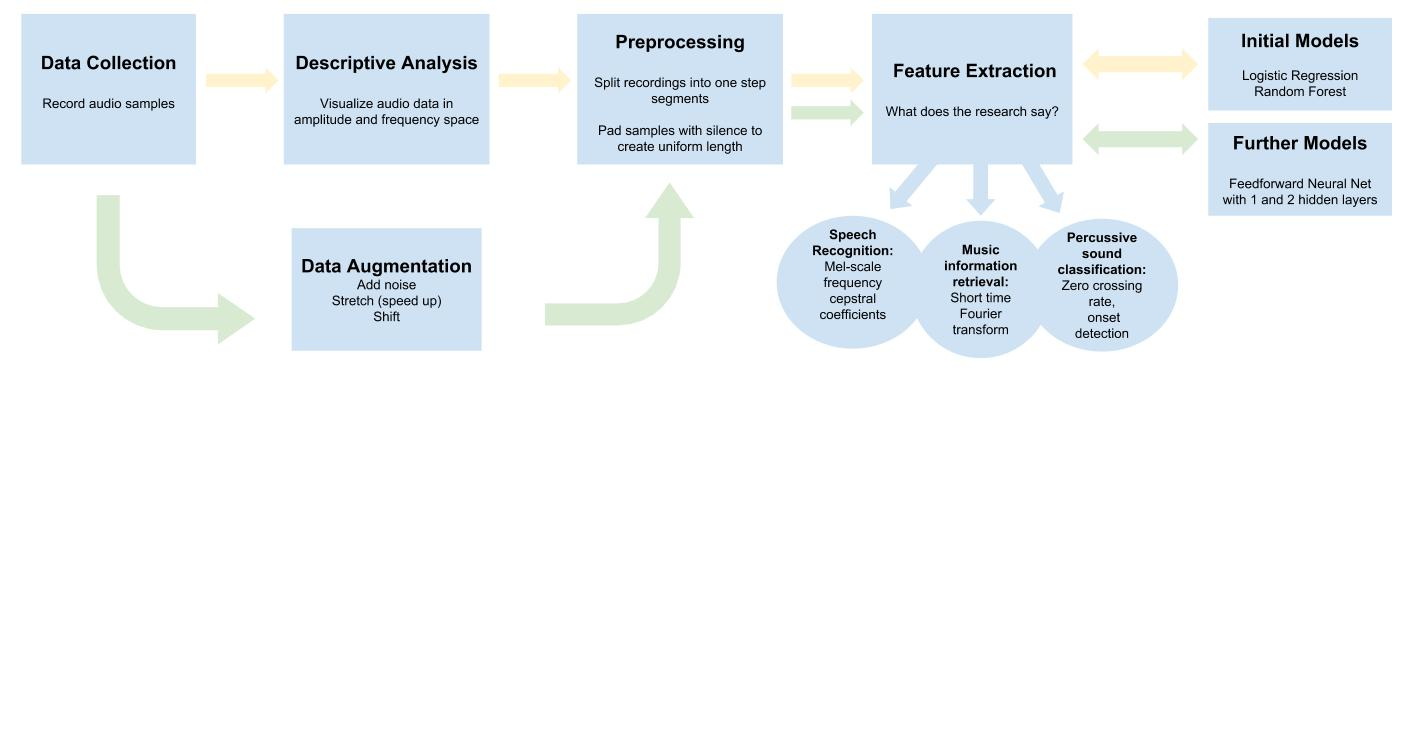

In [16]:
#Image('../../../Source/Data/MLWorkflowpt1.jpg')
Image('../../../Source/Data/MLWorkflowpt2.jpg')

## Data Collection

### Step 1:
- Record samples from volunteers, with different shoes, at different speeds
- Export all recordings as wav files
### Step 2: 
- Check dBFS for all files
- Use results in next step
### Step 3:
- Cut files into chunks (split on silence) and export
- Audibly check files with pydub
- Sort out clips without 2 sounds
- Visually check files with librosa <br/>
While it might seem time consuming to actually listen to all of these clips, it isn't all that crazy considering each root file is no more than 60 seconds long in total. I decided that the time trade-off is worth it to have clean, true data.


Before: 


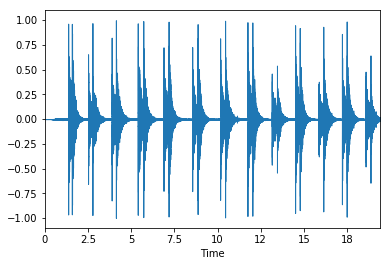

In [14]:
print('Before: ')
Image('../../../Source/Data/Manyshuffles.png')

After: 


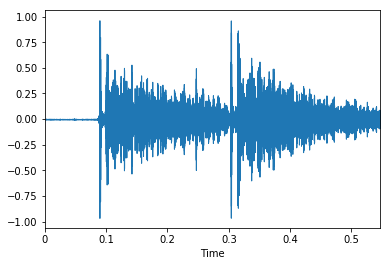

In [15]:
print('After: ')
Image('../../../Source/Data/Oneshuffle.png')

## Descriptive Analysis
Visualizing the data, and jumping in the deep-end of digital signal processing

**Where's the magic?**<br/> In the Short Time Fourier Transform (STFT)
 <br/><br/>***Why?***<br/>
 This transformation allows us to capture information or patterns in the signal's frequency in discrete, short windows of time. By placing them next to one another, we can visualize the signal's frequency as it changes over time (spectrogram)